# Project 3: Predictive modeling
*University of Ljubljana, Faculty for computer and information science* <br />
*Course: Introduction to data science*

In this Jupyter notebook you should document all the analyses (tables, figures, models) you have perfomed to write your report.

All the code in the notebook must be reproducible and runnable, so include instructions for the environment setup or other specifics needed to run the notebook.

## Environment setup

In the repository I included a yml file with all needed dependencies for this notebook to run. You can create a conda environment with the following command:

`conda env create -f environment.yml`

After creating it, you activate it by `conda activate ids-proj-3`. When you start jupyter notebook you need to select kernel with name `Python [conda env:ids-proj-3]`.

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib


from sklearn.metrics import mean_squared_error, make_scorer

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier

In [ ]:
pd.options.mode.chained_assignment = None

## Identifying anonymous users

In [91]:
usage = pd.read_csv('data/Celtra platform usage data.csv')
sessions = pd.read_csv('data/Celtra sessions data.csv')

First we filter out all anonymous users.

In [92]:
known_user = usage[usage['USER'] != '(anonymous)']

In [86]:
print(f"Activity locations not used by any real user: {', '.join(np.setdiff1d(usage['ACTIVITYLOCATION'].unique(), known_user['ACTIVITYLOCATION'].unique()))}")


Activity locations not used by any real user: socialLinkDialog


Let's test if a user can be logged in and anonymous in the same session - then you could directly know which user that is.

In [87]:
users_one_session = usage[['USER', 'SESSION']].groupby('SESSION').agg('nunique').sort_values(by='USER', ascending=False)
print(f"Number of such sessions: {users_one_session[users_one_session['USER'] == 2].size}")

Number of such sessions: 19179


In [88]:
print(f"Number of anonymous users sessions: {usage[usage['USER'] == '(anonymous)'].groupby('SESSION').agg('nunique').size}")


Number of anonymous users sessions: 217925


Can there be a session with two known users?

In [89]:
known_users_one_session = usage[usage['USER'] != '(anonymous)'][['USER', 'SESSION']].groupby('SESSION').agg('nunique')
print(f"Number of such sessions: {known_users_one_session[known_users_one_session['USER'] == 2].size}")

Number of such sessions: 0


Prepare numerical data

In [93]:
known_user['DATE'] = pd.to_datetime(known_user['TIMESTAMP']).dt.dayofyear
known_user['HOUR'] = pd.to_datetime(known_user['TIMESTAMP']).dt.hour
known_user['MIN'] = pd.to_datetime(known_user['TIMESTAMP']).dt.hour * 60 + pd.to_datetime(known_user['TIMESTAMP']).dt.minute
known_user = known_user.drop(['TIMESTAMP', 'ACTIVITY'], axis=1)

known_user.shape

(515024, 7)

For testing we will take only sessions on the platforms that anonymous user can use.
Project 2: users still log in ~ 75% of time when they don't need to.
--> for test set we will take 25% of activity locations that can be used without logging in for each user.

In [ ]:
no_log_in = ['campaignExplorer', 'comments', 'adBuilder', 'previewPage', 'socialLinkDialog', 'demoPage', 'creativeExport']
# no_log_in = [actloc_dict[act] for act in no_log_in_text]

np.random.seed(0)

test_idx = []
for user in known_user['USER'].unique():
    test_idx.append(known_user[(known_user['USER'] == user) & (known_user['ACTIVITYLOCATION'].isin(no_log_in))]
                    .sample(frac=0.25).index.values)
test_idx = np.concatenate(test_idx)

# joblib.dump(test_idx, 'test_index.joblib')

Second version of our model will take train and test set sepparated in a point in time.
We will again take 25% of activity locations that can be used without logging for test set, but the difference will
be that we won't take those randomly, but will take the last quarter.

In [ ]:
df_no_login = known_user[known_user['ACTIVITYLOCATION'].isin(no_log_in)].index.values
test_idx_timesplit = df_no_login[round(len(df_no_login)*0.75):]

# joblib.dump(test_idx_timesplit, 'test_index_timesplit.joblib')

Models are trained in separate files. Parameters are evaluated in `svc_kfold.py`, `pipeline_kfold.py` and
`kfold_timesplit`.
Let's look at the results of RandomizedSearchCV with KFold cross validation.

In [ ]:
svc_kfold_results = joblib.load('svm_results_acc.joblib').cv_results_
pipeline_kfold_results = joblib.load('pipeline_results_acc.joblib').named_steps.randomizedsearchcv.cv_results_

In [94]:
results = pd.DataFrame(columns=['parameters', 'model', 'mean_accuracy', 'std_accuracy'])
for i in range(len(svc_kfold_results['params'])):
    results.loc[2*i] = [', '.join(str(x) for x in svc_kfold_results['params'][i].values()), 'SVC',
                        svc_kfold_results['mean_test_score'][i], svc_kfold_results['std_test_score'][i]]
    results.loc[2*i + 1] = [', '.join(str(x) for x in pipeline_kfold_results['params'][i].values()), 'PCA + SVC',
                            pipeline_kfold_results['mean_test_score'][i], pipeline_kfold_results['std_test_score'][i]]
results

,parameters,model,mean_accuracy,std_accuracy
0,"linear, 0.001, 0.1",SVC,0.914199,0.005991
1,"linear, 0.001, 0.1",PCA + SVC,0.979670,0.001526
2,"rbf, 0.001, 1",SVC,0.926060,0.009962
3,"rbf, 0.001, 1",PCA + SVC,0.977526,0.003246
4,"rbf, 0.1, 1",SVC,0.990034,0.001959
5,"rbf, 0.1, 1",PCA + SVC,0.989637,0.001224
6,"rbf, 1, 1",SVC,0.961085,0.006608
7,"rbf, 1, 1",PCA + SVC,0.984594,0.001693
8,"rbf, 0.1, 5",SVC,0.991078,0.001656
9,"rbf, 0.1, 5",PCA + SVC,0.989954,0.001067


In [95]:
svc_kfold_time = joblib.load('svm_results_time_rbf.joblib').cv_results_
svc_best = svc_kfold_time['params'][np.argmin(svc_kfold_time['rank_test_score'])]
print(f"Best parameters for SVC on train/test set split by time: {svc_best}")

Best parameters for SVC on train/test set split by time: {'kernel': 'rbf', 'gamma': 0.01, 'C': 5}


Results of training with best parameters on whole dataset on randomly chosen test data:

In [ ]:
# preparing test set
df1 = pd.get_dummies(known_user[['ACCOUNT', 'USER', 'ACTIVITYLOCATION', 'DATE', 'MIN']], columns=['ACTIVITYLOCATION', 'ACCOUNT'])
usage_test = df1.loc[test_idx]
X_test = usage_test.loc[:, usage_test.columns != 'USER']
y_test = usage_test['USER']

In [ ]:
# loading models, trained in separate files
model_svm = joblib.load('svm_users_acc.joblib')
model_pca_svm = joblib.load('pipeline_users_acc.joblib')
model_xgb = joblib.load('xgboost_users.joblib')

In [ ]:
y_svm = model_svm.predict(X_test)
sc_svm = sum(np.equal(y_svm, y_test.values)) / len(y_svm)

In [96]:
print(f"Predicting with SVM was {round(sc_svm*100, 2)}% accurate.")

Predicting with SVM was 95.39% accurate.


In [ ]:
y_pca_svm = model_pca_svm.predict(X_test)
sc_pca_svm = sum(np.equal(y_pca_svm, y_test.values)) / len(y_pca_svm)

In [97]:
print(f"Predicting with PCA + SVM was {round(sc_pca_svm*100,2)}% accurate.")

Predicting with PCA + SVM was 93.53% accurate.


In [ ]:
y_xgb = model_xgb.predict(X_test)
sc_xgb = sum(np.equal(y_xgb, y_test.values)) / len(y_xgb)

In [98]:
print(f"Predicting with XGBoost was {round(sc_xgb*100, 2)}% accurate.")

Predicting with XGBoost was 61.24% accurate.


Accuracy of majority classifier on such train/test split:

In [ ]:
y_train = df1.drop(test_idx)['USER']
most_common = y_train.value_counts().idxmax()
sc_majority = sum(np.equal(np.repeat(most_common, len(y_test)), y_test.values)) / len(y_test)

In [99]:
print(f"Predicting the majority user is {round(sc_majority*100, 2)}% accurate.")

Predicting the majority user is 7.65% accurate.


Results of training on whole dataset on test data chosen by a point in time:

In [ ]:
# defining test set
usage_test_ts = df1.loc[test_idx_timesplit]
X_test_ts = usage_test_ts.loc[:, usage_test_ts.columns != 'USER']
y_test_ts = usage_test_ts['USER']

In [ ]:
# loading models that were trained in separate files
model_svm_ts = joblib.load('svm_users_timesplit.joblib')
model_pca_svm_ts = joblib.load('pipeline_users_timesplit.joblib')
model_xgb_ts = joblib.load('xgboost_users_timesplit.joblib')

In [ ]:
y_svm_ts = model_svm_ts.predict(X_test_ts)
sc_svm_ts = sum(np.equal(y_svm_ts, y_test_ts.values)) / len(y_svm_ts)

In [100]:
print(f"Predicting with SVM was {round(sc_svm_ts*100, 2)}% accurate.")

Predicting with SVM was 94.62% accurate.


In [ ]:
y_pca_svm_ts = model_pca_svm_ts.predict(X_test_ts)
sc_pca_svm_ts = sum(np.equal(y_pca_svm_ts, y_test_ts.values)) / len(y_pca_svm_ts)

In [101]:
print(f"Predicting with PCA + SVM was {round(sc_pca_svm_ts*100,2)}% accurate.")

Predicting with PCA + SVM was 92.76% accurate.


In [ ]:
y_xgb_ts = model_xgb_ts.predict(X_test_ts)
sc_xgb_ts = sum(np.equal(y_xgb_ts, y_test_ts.values)) / len(y_xgb_ts)

In [102]:
print(f"Predicting with XGBoost was {round(sc_xgb_ts*100,2)}% accurate.")

Predicting with XGBoost was 37.82% accurate.


Accuracy of majority classifier on such train/test split:

In [103]:
y_train_ts = df1.drop(test_idx_timesplit)['USER']
most_common_ts = y_train_ts.value_counts().idxmax()
sc_majority_ts = sum(np.equal(np.repeat(most_common_ts, len(y_test_ts)), y_test_ts.values)) / len(y_test)
print(f"Predicting the majority user is {round(sc_majority_ts*100, 2)}% accurate.")

Predicting the majority user is 7.61% accurate.


In [114]:
fi = model_xgb.feature_importances_

feature_imp = dict(zip(X_test.columns[:2], fi[:2]))
feature_imp['ACTIVITYLOC'] =  sum(fi[2:-11])
feature_imp['ACCOUNT'] = sum(fi[-11:])

In [122]:
X_test.columns[np.where(fi == 0)].values

array(['ACTIVITYLOCATION_accountAddOns', 'ACTIVITYLOCATION_accountDemo',
       'ACTIVITYLOCATION_accountPartners',
       'ACTIVITYLOCATION_accountSettings',
       'ACTIVITYLOCATION_addDemoCreativeDialog',
       'ACTIVITYLOCATION_batchesUsingFeedDialog',
       'ACTIVITYLOCATION_campaignArchiveDialog',
       'ACTIVITYLOCATION_demoPage',
       'ACTIVITYLOCATION_editCampaignCountryDialog',
       'ACTIVITYLOCATION_editCustomAttributeDialog',
       'ACTIVITYLOCATION_editMassProductionDialog',
       'ACTIVITYLOCATION_folderArchiveDialog',
       'ACTIVITYLOCATION_newSubFolderDialog',
       'ACTIVITYLOCATION_userGroupDialog'], dtype=object)

In [119]:
fi_ts = model_xgb_ts.feature_importances_
feature_imp_ts = dict(zip(X_test.columns[:2], fi_ts[:2]))
feature_imp_ts['ACTIVITYLOC'] =  sum(fi_ts[2:-11])
feature_imp_ts['ACCOUNT'] = sum(fi_ts[-11:])

In [123]:
X_test.columns[np.where(fi_ts == 0)].values

array(['ACTIVITYLOCATION_accountAddOns',
       'ACTIVITYLOCATION_accountPartners',
       'ACTIVITYLOCATION_accountSettings',
       'ACTIVITYLOCATION_addDemoCreativeDialog',
       'ACTIVITYLOCATION_addUserDialog',
       'ACTIVITYLOCATION_batchesUsingFeedDialog',
       'ACTIVITYLOCATION_campaignArchiveDialog',
       'ACTIVITYLOCATION_creativeArchiveDialog',
       'ACTIVITYLOCATION_demoPage',
       'ACTIVITYLOCATION_distributionPage/editFacebookAdSetDestinationDialog',
       'ACTIVITYLOCATION_editBatchSpecMassProductionDialog',
       'ACTIVITYLOCATION_editCampaignCountryDialog',
       'ACTIVITYLOCATION_editCustomAttributeDialog',
       'ACTIVITYLOCATION_feedImportDialog',
       'ACTIVITYLOCATION_folderArchiveDialog',
       'ACTIVITYLOCATION_moveCreativesDialog',
       'ACTIVITYLOCATION_newCustomFeedDialog',
       'ACTIVITYLOCATION_userApiApps'], dtype=object)

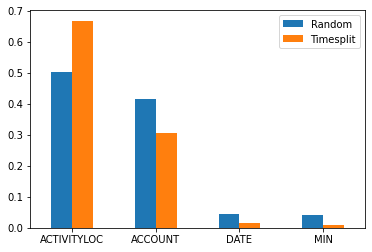

In [121]:
df = {'Random': feature_imp, 'Timesplit': feature_imp_ts,}
pd.DataFrame(df).sort_values(by='Random', ascending=False).plot.bar(rot=0)
plt.savefig('importance.png')
plt.show()

